# Pocc quality assessment feature

## 1. Import code libraries

In [60]:
# Standard code libraries
import os
import sys, platform
import glob

import scipy
from scipy import interpolate as interp
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import numpy.matlib

import matplotlib.pyplot as plt
import ipywidgets as widgets
from datetime import datetime
%matplotlib widget

In [61]:
# Custom code libraries from the ReSurfEMG repository
import resurfemg.preprocessing.ecg_removal as ecg_rm
import resurfemg.preprocessing.envelope as evl
import resurfemg.preprocessing.filtering as filt
import resurfemg.postprocessing.features as feat
import resurfemg.postprocessing.quality_assessment as qa

from resurfemg.data_connector.tmsisdk_lite import Poly5Reader

from resurfemg.config.config import Config

## Initiation of output folder for experiments

In [62]:
# Root directory for patient data
config = Config()
root_patient_data_directory = \
    config.get_directory('synthetic_data_directory')

if platform.system() == 'Windows':
    path_sep = "\\"
else:
    path_sep = '/'

patient_idx = 0

## 2. Load the ventilator and sEMG data

2.a Select a patient

In [63]:
# Select the patient of interest
# Expected data structure:
# - Patient_01
# -- Measurement_date_XXXX_XX_01
# --- 001_Baseline
# --- 002_PEEP_step_01
# --- 003_PEEP_step_02
# --- 004_PEEP_step_03
# --- 005_PEEP_step_04
# -- Measurement_date_XXXX_XX_03
# --- 001_Baseline
# --- 002_PEEP_step_01
# --- 003_PEEP_step_02
# --- 004_PEEP_step_03
# --- 005_PEEP_step_04
# -- Patient_02
# -- Measurement_date_XXXX_XX_01
# etc.

# NB Run this cell once per patient!
patient_folders_tmp = \
    glob.glob(root_patient_data_directory + '/**/', recursive=False)

patient_folders = list()
for _, patient_folder in enumerate(patient_folders_tmp):
    patient_folders.append(os.path.normpath(patient_folder))

patients = []
for folder in patient_folders:
    name = folder.split(path_sep)[-1]
    patients.append(name)

btn_pt = widgets.Dropdown(  
    options=patients,
    value=patients[patient_idx],
    description='Select patient:',
    disabled=False,
)

date_idx = 0

display(btn_pt)

Dropdown(description='Select patient:', options=('HSP001',), value='HSP001')

2.b Select a measurement date, or PEEP trial

In [64]:
# Select the PEEP trial of interest for the selected patient
# measurement_date ~ PEEP-trial
 
# NB Run this cell once per patient/PEEP trial combination

patient = btn_pt.value
patient_idx =btn_pt.index

measurement_folders_tmp = glob.glob(root_patient_data_directory 
                                + '/' + patient 
                                + '/**/',
                                recursive=False
                                )
measurement_folders = list()
for _, measurement_folder in enumerate(measurement_folders_tmp):
    measurement_folders.append(os.path.normpath(measurement_folder))

measurement_dates = []

for folder in measurement_folders:
    name = folder.split(path_sep)[-1]
    measurement_dates.append(name)

# Initialise the analysis: empty the output parameter list and start at the 
# first recorded PEEP step (index -4)
big_data_list = []
PEEP_step_idx = -4

btn_measurement = widgets.Dropdown(
    options=measurement_dates,
    value=measurement_dates[date_idx],
    description='Select measurement date:',
    disabled=False,
)
display(btn_measurement)

Dropdown(description='Select measurement date:', options=('XXXX_XX_XX_measurement_01',), value='XXXX_XX_XX_mea…

2.c Select a PEEP step

In [65]:
# Identify all recordings available for the selected patient/measurement_date

# NB Re-run this cell for each new PEEP trial, as it also empties output 
# parameter list (big_data_list)!

# Identify all PEEP step folders:
measurement_date = btn_measurement.value
date_idx = btn_measurement.index

windows_str = (root_patient_data_directory + '/' + patient + '/' 
               + measurement_date)
root_emg_directory = os.path.join(windows_str)

emg_pattern = os.path.join(root_emg_directory, '**/*.Poly5')
emg_and_vent_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
vent_files = []

for file in emg_and_vent_files:
    if 'Draeger' in file:
        vent_files.append(file)
    else:
        emg_files.append(file)
list_of_numbers_string = []

for i in range(len(emg_files)):
    list_of_numbers_string.append(emg_files[i].split(path_sep)[-2])

# Select the PEEP step of interest. The selection menu initialises at the third 
# but last (index -4) recording. The PEEP steps are named after the folders 
# containing the data files (.poly5) of interest.

btn_PEEP_step = widgets.Dropdown(
    options=list_of_numbers_string,
    value=str(emg_files[PEEP_step_idx].split(path_sep)[-2]),
    description='Picked File:',
    disabled=False,
)
display(btn_PEEP_step)

Dropdown(description='Picked File:', index=1, options=('000', '001', '002', '003', '004'), value='001')

In [123]:
# Process selected option: the PEEP step of interest  
PEEP_step_chosen = btn_PEEP_step.value
PEEP_step_idx = int(btn_PEEP_step.index)
emg_file_chosen = emg_files[PEEP_step_idx]
vent_file_chosen = vent_files[PEEP_step_idx]
print("The chosen files are:\n", emg_file_chosen, '\n', vent_file_chosen)

The chosen files are:
 C:/Users/warnaarrsp/repos/ReSurfEMG_ReSurfEMG/not_pushed/synthetic_data/HSP001/XXXX_XX_XX_measurement_01\002\emg_data_synth.Poly5 
 C:/Users/warnaarrsp/repos/ReSurfEMG_ReSurfEMG/not_pushed/synthetic_data/HSP001/XXXX_XX_XX_measurement_01\002\Draeger_data_synth.Poly5


In [124]:
# Load the EMG and ventilator data recordings from the selected folders.
data_emg = Poly5Reader(emg_file_chosen)
data_vent = Poly5Reader(vent_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
emg_fs = data_emg.sample_rate
data_vent_samples = data_vent.samples[:data_vent.num_samples]
vent_fs = data_vent.sample_rate

# Define the time series of the EMG and ventilator recordings
y_emg = data_emg_samples
y_vent = data_vent_samples

# Define the time axes
t_emg = [i/emg_fs for i in range(len(y_emg[0, :]))]
t_vent = [i/vent_fs for i in range(len(y_vent[0, :]))]

# Default settings for window of interest including the end-expiratory occlusion
# manoeuvres (Pocc)
t_start_default = t_vent[-1]-60
t_end_default = t_vent[-1]-5

Reading file  C:/Users/warnaarrsp/repos/ReSurfEMG_ReSurfEMG/not_pushed/synthetic_data/HSP001/XXXX_XX_XX_measurement_01\002\emg_data_synth.Poly5
	 Number of samples:  860160 
	 Number of channels:  2 
	 Sample rate: 2048 Hz
Done reading data.
Reading file  C:/Users/warnaarrsp/repos/ReSurfEMG_ReSurfEMG/not_pushed/synthetic_data/HSP001/XXXX_XX_XX_measurement_01\002\Draeger_data_synth.Poly5
	 Number of samples:  42000 
	 Number of channels:  3 
	 Sample rate: 100 Hz
Done reading data.


In [125]:
# # Plot the raw data
# fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 6))

# axis[0, 0].grid(True)
# axis[0, 0].plot(t_emg, y_emg[0])
# axis[0, 0].set(title='sEMG leads')
# axis[0, 0].set_ylabel('ECG (uV)')
# axis[1, 0].plot(t_emg, y_emg[1])
# axis[1, 0].set_ylabel('sEMGdi (uV)')
# axis[1, 0].set_xlabel('t (s)')
# axis[2, 0].axis('off')

# axis[0, 1].set(title='Ventilator data')
# axis[0, 1].grid(True)
# axis[0, 1].plot(t_vent, y_vent[0])
# axis[0, 1].set_ylabel('Paw (cmH2O)')
# axis[1, 1].plot(t_vent, y_vent[1])
# axis[1, 1].set_ylabel('F (L/min)')
# axis[2, 1].plot(t_vent, y_vent[2])
# axis[2, 1].set_ylabel('V (mL)')
# axis[2, 1].set_xlabel('t (s)')

## 3. Select the time window of interest

Enter the start and end time of the window in which the occlusions occur. Make sure to take some margin around the peaks in the order of a couple of seconds to allow for the filtering algorithms to work properly. On the other hand, if the window is to broad, the algorithms will also take longer to evaluate.

In [126]:
# Window selection

start_widget = widgets.BoundedFloatText(
    value=np.floor(t_start_default),
    min=1,
    max=t_vent[-1],
    step=1,
    description='Start:',
    disabled=False
)
end_widget = widgets.BoundedFloatText(
    value=np.floor(t_end_default),
    min=1,
    max=t_vent[-1],
    step=1,
    description='End:',
    disabled=False
)
widgets.VBox([start_widget, end_widget])

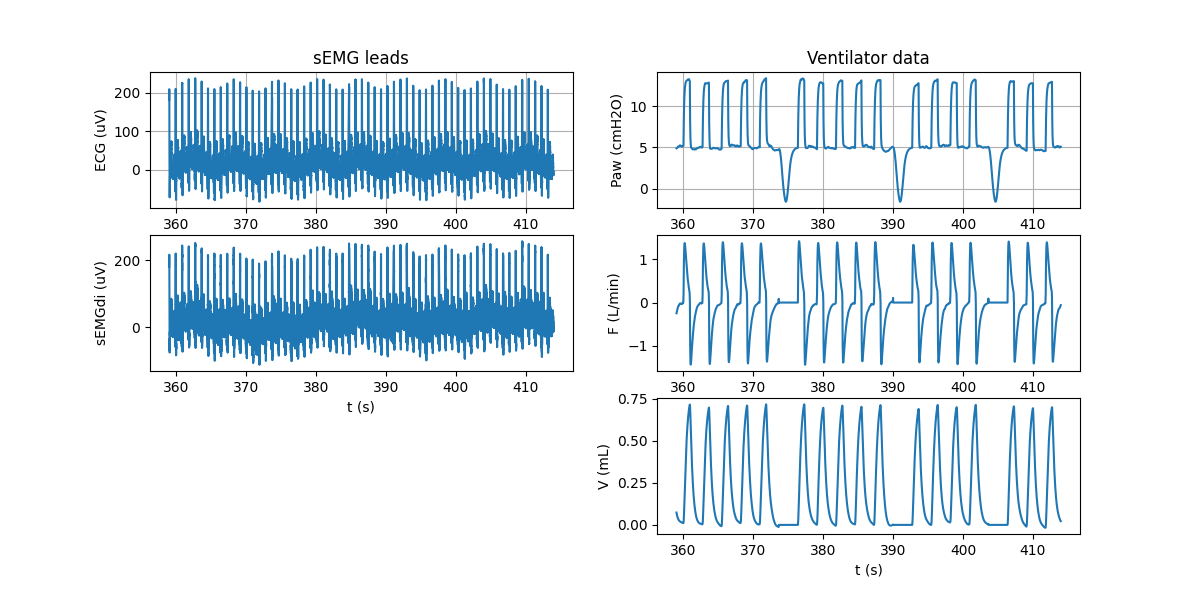

In [127]:
# Plot the selected window if valid start and end times are entered
start = start_widget.value  
end = end_widget.value  
if ((0 > start) | (t_vent[-1] < start) | (0 > end) | (t_vent[-1] < end) 
    | (start >= end)):    
    print('Please make sure that 1) the start and end times are within the'  
          +' limits of the recording and 2) that the start time is before the' 
          + ' end time.')
else:
    # Plot the selected window.
    start_idx = int(float(start)* emg_fs)
    end_s = min([int(float(end)*emg_fs), len(y_emg[0,:])-1])
    start_vent_s = int(float(start)* vent_fs)
    end_vent_s = min(
        [int(float(end)* vent_fs), len(y_vent[0,:])-1]
    )

    fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(12, 6))
    axis[0, 0].set(title='sEMG leads')
    axis[0, 0].grid(True)
    axis[0, 0].plot(t_emg[int(start_idx):int(end_s)], 
                    y_emg[0][int(start_idx):int(end_s)])
    axis[0, 0].set_ylabel('ECG (uV)')
    axis[1, 0].plot(t_emg[int(start_idx):int(end_s)], 
                    y_emg[1][int(start_idx):int(end_s)])
    axis[1, 0].set_ylabel('sEMGdi (uV)')
    axis[1, 0].set_xlabel('t (s)')
    
    axis[2, 0].axis('off')

    axis[0, 1].set(title='Ventilator data')
    axis[0, 1].grid(True)
    axis[0, 1].plot(
        t_vent[int(start_vent_s):int(end_vent_s)], 
        y_vent[0][int(start_vent_s):int(end_vent_s)]
    )
    axis[0, 1].set_ylabel('Paw (cmH2O)')
    axis[1, 1].plot(
        t_vent[int(start_vent_s):int(end_vent_s)], 
        y_vent[1][int(start_vent_s):int(end_vent_s)]
    )
    axis[1, 1].set_ylabel('F (L/min)')
    axis[2, 1].plot(
        t_vent[int(start_vent_s):int(end_vent_s)], 
        y_vent[2][int(start_vent_s):int(end_vent_s)]
    )
    axis[2, 1].set_ylabel('V (mL)')
    axis[2, 1].set_xlabel('t (s)')

Examine at the selected window:
1. Does it contain all occlusions? If not, adapt the start and/or end time to include all Pocc manoeuvres.
2. Does the window contain limited data before and after the occlusions (~10 s). If noy, you can adapt the start and/or end time to optimise calculation speed.

## 4. Pre-process the sEMGdi

In [128]:
# # Set the default pipeline parameters
# # Gating settings
# gate_width_default = 0.10
# gate_threshold_default = 0.30
# gate_ECG_shift_default = -10
# gate_twice = False

# # RMS window
# RMS_window_ms_default = 200

# # Peak detection settings
# time_shift_default = 0.5 - RMS_window_ms_default/1000/2
P_occ_prominence_factor_default = 0.8
# sEAdi_prominence_factor_default = 0.5

In [129]:
# # Eliminate the baseline wander from the data using a band-pass filter
# bd_filtered_file_data = filt.emg_bandpass_butter_sample(
#     data_emg_samples, 1, 500, 2048, output='sos')
    
# processed_data_emg_di = bd_filtered_file_data[1]

In [130]:
# # Gating settings

# # Window size to plot the gating results from
# plot_window = 5         

# # QRS peak detection settings
# # peak_fraction = 0.30 (default value)
# peak_fraction = gate_threshold_default     # Minimal relative peak height
# peak_width = 0.001
# peak_dist = int(emg_fs/3)

# # Shift of gated in samples relative to detected peaks      
# # ECG_shift = -10 (default value)
# ECG_shift = gate_ECG_shift_default

# # Gate width in seconds
# # gate_width = 0.10 (default value)
# gate_width = gate_width_default

Apply QRS gating

In [131]:
# # First run of QRS gating

# # Detect ECG peaks on 1Hz high-pass filtered signals
# ecg = bd_filtered_file_data[0]
# ecg_rms = evl.full_rolling_rms(ecg, 10)
# max_ecg_rms = max(
#     ecg_rms[int(start_idx):int(start_idx+plot_window*emg_fs)])
# min_ecg_rms = min(
#     ecg_rms[int(start_idx):int(start_idx+plot_window*emg_fs)])
# peak_height = peak_fraction*(max_ecg_rms - min_ecg_rms)

# ECG_peaks, properties  = scipy.signal.find_peaks(
#     ecg_rms, 
#     height=peak_height, 
#     width=peak_width*emg_fs, 
#     distance=peak_dist
# )

# # The RMS filter is not centred. Therefore, shift the ECG peak locations
# ECG_peaks = ECG_peaks - ECG_shift

# # Filter EXG signals 20Hz high pass
# ECG_h20 = filt.emg_bandpass_butter_sample(ecg, 20, 500, 2048, output='sos')
# emg_di_h20 = filt.emg_bandpass_butter_sample(
#     processed_data_emg_di, 20, 500, 2048, output='sos')

# # Gate ECG and EMG signal
# # Fill methods 0: Zeros, 1: Interpolate start-end, 2: Average prior data, 
# # 3: Moving average
# gate_fill_method = 3    
# gate_width_samples = int(gate_width*emg_fs)

# gate_samples = list()
# for i in range(len(ECG_peaks)):
#     for k in range(
#         int(ECG_peaks[i]-gate_width_samples/2),
#         int(ECG_peaks[i]+gate_width_samples/2)
#     ):
#         gate_samples.append(k)

# ECG_gated = ecg_rm.gating(
#     ECG_h20, ECG_peaks, gate_width=gate_width_samples, method=3)
# emg_di_gated = ecg_rm.gating(
#     emg_di_h20, ECG_peaks, gate_width=gate_width_samples, method=3)


In [132]:
# # Second run of QRS gating, if selected with gate_twice == True
# # This is usefull, e.g., in case of splitted QRS complex or pacing
# if gate_twice == True:
#     # Detect ECG peaks on 1Hz high-pass filtered signals
#     ecg = ECG_gated
#     ecg_rms = evl.full_rolling_rms(ecg, 10)
#     max_ecg_rms = max(
#         ecg_rms[int(start_idx):int(start_idx+plot_window*emg_fs)])
#     min_ecg_rms = min(
#         ecg_rms[int(start_idx):int(start_idx+plot_window*emg_fs)])
#     peak_height = peak_fraction*(max_ecg_rms - min_ecg_rms)

#     ECG_peaks, properties  = scipy.signal.find_peaks(
#         ecg_rms, 
#         height=peak_height, 
#         width=peak_width*emg_fs, 
#         distance=peak_dist
#     )
#     # The RMS filter is not centred. Therefore, shift the ECG peak locations
#     ECG_peaks = ECG_peaks - ECG_shift

#     # Gate ECG and EMG signal
#     # Fill methods: 0: Zeros, 1: Interpolate start-end, 2: Average prior data, 
#     # 3: Moving average
#     gate_fill_method = 3    
#     gate_width_samples = int(gate_width*emg_fs)

#     gate_samples = list()
#     for i in range(len(ECG_peaks)):
#         for k in range(
#             int(ECG_peaks[i]-gate_width_samples/2),
#             int(ECG_peaks[i]+gate_width_samples/2)
#         ):
#             gate_samples.append(k)

#     ECG_gated = ecg_rm.gating(
#         ECG_gated, ECG_peaks, gate_width=gate_width_samples, method=3)
#     emg_di_gated = ecg_rm.gating(
#         emg_di_gated, ECG_peaks, gate_width=gate_width_samples, method=3)

In [133]:
# # Plot gating result
# fig, axis = plt.subplots(nrows=4, ncols=1, figsize=(12, 6))
# start_i = int(start_idx)
# end_i = int(start_idx+plot_window*2048)
# axis[0].grid(True)
# axis[0].plot(t_emg[start_i:end_i], bd_filtered_file_data[0, start_i:end_i])
# axis[0].set_ylabel('raw ECG (uV)')
# axis[0].set(title='leads in EMG')
# axis[1].grid(True)
# axis[1].plot(t_emg[start_i:end_i], ECG_gated[start_i:end_i])
# axis[1].set_ylabel('ECG gated (uV)')
# axis[2].grid(True)
# axis[2].plot(t_emg[start_i:end_i], emg_di_gated[start_i:end_i])
# axis[2].set_ylabel('EMGdi gated (uV)')
# axis[3].grid(True)
# axis[3].plot(t_emg[start_i:end_i], ecg_rms[start_i:end_i])
# axis[3].set_ylabel('ECG rms (uV)')
# axis[3].hlines(
#     y=peak_height, 
#     xmin=t_emg[start_i], 
#     xmax=t_emg[end_i],
#     color = "C1"
# )
# axis[3].set_xlabel('t (s)')

# for idx in range(len(ECG_peaks)):
#     if ((ECG_peaks[idx] > int(start_idx)) 
#         & (ECG_peaks[idx] < int(start_idx+plot_window*2048))):
#         axis[3].plot(t_emg[ECG_peaks[idx]], ecg_rms[ECG_peaks[idx]],'rx')


## 5. Calculate the sEMGdi envelope (sEAdi)

In [134]:
# # Calculate the moving-RMS over the sEMG signal
# # RMS_window_ms = 200 (default value)
# RMS_window_ms = RMS_window_ms_default

# RMS_windows_samp = int(RMS_window_ms / 1000 *  emg_fs)

# # Pad the EMG signal before gating to get a centralised, rather than a causal
# # moving RMS signal
# pre_samp = int(np.ceil(RMS_windows_samp/2))
# post_samp = int(np.floor(RMS_windows_samp/2))
# padding_pre = np.zeros((pre_samp,))
# padding_end = np.zeros((post_samp,))
# emg_di_gated_padded = np.concatenate((padding_pre, emg_di_gated, padding_end))

# sEAdi_padded = evl.full_rolling_rms(emg_di_gated_padded, RMS_windows_samp)
# sEAdi = sEAdi_padded[:-RMS_windows_samp]

# # Plot RMS results
# fig, axis = plt.subplots(nrows=3, ncols=1, figsize=(12, 6))
# axis[0].set(title='leads in EMG')
# axis[0].set_ylabel('sEMGdi (uV)')
# axis[0].grid(True)
# axis[0].plot(t_emg[int(start_idx):int(end_s)], 
#              processed_data_emg_di[int(start_idx):int(end_s)])
# axis[0].plot(t_emg[int(start_idx):int(end_s)], sEAdi[int(start_idx):int(end_s)])

# axis[1].set_xlabel('t (s)')
# axis[1].set_ylabel('sEAdi (uV)')
# axis[1].plot(t_emg[int(start_idx):int(end_s)], sEAdi[int(start_idx):int(end_s)])
# axis[2].set_ylabel('Paw (cmH2O)')
# axis[2].grid(True)
# axis[2].plot(t_vent[int(start_vent_s):int(end_vent_s)], 
#              y_vent[0][int(start_vent_s):int(end_vent_s)])
# axis[2].set_xlabel('t (s)')


## 6. Calculate the Paw and sEAdi moving baselines

In [135]:
# # Old moving baseline on pressure and EMG signals for baseline crossing 
# # detection in accordance with Graßhoff et al. (2021)

# baseline_W_emg = 5 * emg_fs  # window length
# baseline_W_vent = 5 * vent_fs  # window length

# sEAdi_rolling_baseline_old = np.zeros(
#     (len(sEAdi[int(start_idx):int(end_s)]), ))

# for idx in range(0, int(end_s)-int(start_idx), int(emg_fs/5)):
#     start_i = max([int(start_idx), int(start_idx)+idx-int(baseline_W_emg/2)])
#     end_i = min([int(end_s), int(start_idx)+idx+int(baseline_W_emg/2)])
#     baseline_value_emg_di = np.percentile(
#         sEAdi[start_i:end_i], 33)
    
#     for i in range(idx, 
#                    min([idx+int(emg_fs/5), int(end_s)-int(start_idx)])
#     ):
#         sEAdi_rolling_baseline_old[i] = baseline_value_emg_di

In [136]:
# Augmented moving baseline for EMG signals for baseline crossing detection

# Baseline windows
baseline_W_emg = int(7.5 * emg_fs)  # window length
baseline_W_vent = int(7.5 * vent_fs)  # window length

# 1. Calculate the default moving baselines
P_rolling_baseline = np.zeros(
    (len(y_vent[0, int(start_vent_s):int(end_vent_s)]), ))
# sEAdi_rolling_baseline = np.zeros(
#     (len(sEAdi[int(start_idx):int(end_s)]), ))

# 1.a Calculate the moving baseline over the Paw signal over a 7.5s window
for idx in range(0, 
                 int(end_vent_s)-int(start_vent_s), 
                 int(vent_fs/5)
):
    start_i = max([int(start_vent_s), int(
        start_vent_s)+idx-int(baseline_W_vent/2)])
    end_i = min([int(end_vent_s), int(start_vent_s) +
                idx+int(baseline_W_vent/2)])
    P_rolling_baseline[idx] = np.percentile(y_vent[0, start_i:end_i], 33)

    baseline_value_P = np.percentile(y_vent[0, start_i:end_i], 33)
    for i in range(idx, 
            min([idx+int(vent_fs/5), 
                 int(end_vent_s)-int(start_vent_s)])
    ):
        P_rolling_baseline[i] = baseline_value_P

# # 1.b. Calculate the "default" moving baseline over the sEAdi data over a 7.5s 
# #     window
# for idx in range(0, int(end_s)-int(start_idx), int(emg_fs/5)):
#     start_i = max([int(start_idx), int(start_idx)+idx-int(baseline_W_emg/2)])
#     end_i = min([int(end_s), int(start_idx)+idx+int(baseline_W_emg/2)])
#     baseline_value_emg_di = np.percentile(
#         sEAdi[start_i:end_i], 33)
    
#     for i in range(idx, 
#                    min([idx+int(emg_fs/5), int(end_s)-int(start_idx)])
#     ):
#         sEAdi_rolling_baseline[i] = baseline_value_emg_di

# # 2. Calculate the augmented moving baselines for the sEAdi data
# # 2.a. Rolling standard deviation and mean over 7.5s window
# di_baseline_series = pd.Series(sEAdi_rolling_baseline)
# di_baseline_std = di_baseline_series.rolling(baseline_W_emg, 
#                                  min_periods=1, 
#                                  center=True).std().values
# di_baseline_mean = di_baseline_series.rolling(baseline_W_emg, 
#                                  min_periods=1, 
#                                  center=True).mean().values

# # 2.b. Augmented signal: EMG + abs([dEMG/dt]_smoothed)
# ma_window = window=emg_fs//2
# augmented_perc = 25
# perc_window = emg_fs

# y_di_RMS = sEAdi[int(start_idx):int(end_s)]
# s_di = pd.Series(y_di_RMS - sEAdi_rolling_baseline)
# sEAdi_MA = s_di.rolling(window=ma_window, center=True).mean().values
# dsEAdi_dt = (sEAdi_MA[1:] - sEAdi_MA[:-1] ) * emg_fs
# sEAdi_aug = y_di_RMS[:-1] + np.abs(dsEAdi_dt)

# # 2.c. Run the moving median filter over the augmented signal to obtain the 
# #       baseline
# sEAdi_aug_rolling_baseline = np.zeros(
#     (len(sEAdi[int(start_idx):int(end_s)-1]), ))

# for idx in range(0, int(end_s-1)-int(start_idx), perc_window):
#     start_i = max([0, idx-int(baseline_W_emg)])
#     end_i = min([int(end_s-start_idx-1), idx+int(baseline_W_emg)])

#     baseline_value_emg_di = np.nanpercentile(
#         sEAdi_aug[start_i:end_i], augmented_perc)
    
#     for i in range(idx, 
#                    min([idx+int(perc_window), int(end_s-1)-int(start_idx)])
#     ):
#         sEAdi_aug_rolling_baseline[i] = 1.2 * baseline_value_emg_di

## 7. Identify the Pocc and sEAdi peaks of interest

End-expiratory occlusion (Pocc) detection

In [137]:
# # Peak detection settings
# P_occ_prominence_factor = 0.8 (default value)
P_occ_prominence_factor = P_occ_prominence_factor_default

print("The Pocc detection threshold is set at:\n", 
      100*P_occ_prominence_factor, '%')

The Pocc detection threshold is set at:
 80.0 %


In [138]:
# Detect the set PEEP level

# Find end-expiration samples by finding the minimal values in V_vent
V_vent_up_to_start = y_vent[2][:int(start_vent_s)]
V_ee_PKS, _ = scipy.signal.find_peaks(-V_vent_up_to_start)

# Calculate PEEP as the median value of Paw at end-expiration
PEEP_set = np.round(np.median(y_vent[0, V_ee_PKS])-1)/2*2+1

print("The detected PEEP level is:\n", PEEP_set, ' cmH2O')

The detected PEEP level is:
 5.0  cmH2O


In [139]:
# Detect (negative) occlussion peaks in pressure signal
treshold = 0
width = int(0.1 * vent_fs)
prominence = P_occ_prominence_factor *np.abs( PEEP_set - min(y_vent[0]))
height = -(PEEP_set - P_occ_prominence_factor * 
           np.abs( PEEP_set - min(y_vent[0])))
distance = int(0.5 * vent_fs)

Paw_sel = y_vent[0, int(start_vent_s):int(end_vent_s)]
P_occ_peaks, properties  = scipy.signal.find_peaks(
    -Paw_sel, 
    height=height, 
    prominence=prominence, 
    width=width, 
    distance=distance
)

# Detect Pocc on- and offset using moving baseline crossings
PEEP_crossings_idx = np.argwhere(
    np.diff(np.sign(Paw_sel - P_rolling_baseline)) != 0)

P_occ_starts = np.zeros((len(P_occ_peaks),), dtype=int)
P_occ_ends = np.zeros((len(P_occ_peaks),), dtype=int)
for idx in range(len(P_occ_peaks)):
    PEEP_crossings_idx_sub = np.sign(
        Paw_sel[:P_occ_peaks[idx]] - P_rolling_baseline[:P_occ_peaks[idx]])
    a = np.argmin(
        P_occ_peaks[idx] - np.argwhere(np.diff(PEEP_crossings_idx_sub) != 0))
    P_occ_starts[idx] = int(PEEP_crossings_idx[a])
    P_occ_ends[idx] = int(PEEP_crossings_idx[a+1])

C:\Users\warnaarrsp\AppData\Local\Temp\ipykernel_5792\838692353.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P_occ_starts[idx] = int(PEEP_crossings_idx[a])
C:\Users\warnaarrsp\AppData\Local\Temp\ipykernel_5792\838692353.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P_occ_ends[idx] = int(PEEP_crossings_idx[a+1])


In [140]:
# Data sanity check: Make sure occlusion manoeuvres have been detected
if len(P_occ_starts) == 0 or len(P_occ_peaks) ==0  or len(P_occ_ends) == 0:
    print('No occlussion peaks were detected in the selected window,' 
          + 'please examine the data. Selected another window or file, '
          + 'accordingly')
elif len(P_occ_starts) != len(P_occ_peaks):
    print('Less Pocc peak onsets have been detected than the detected number of'
          + 'peaks. Please examine the data. Selected another window or file, '
          + 'accordingly')
elif len(P_occ_ends) != len(P_occ_peaks):
    print('Less Pocc peak offsets have been detected than the detected number ' 
          + 'ofpeaks. Please examine the data. Selected another window or file,'
          + ' accordingly')
else:
    print(str(len(P_occ_starts)) + ' Pocc manoeuvre(s) were detected. ', 
          'You may continue!')

3 Pocc manoeuvre(s) were detected.  You may continue!


sEAdi peak detection

In [141]:
# # EMG peak detection parameters:

# # Threshold peak height as fraction of max peak height 
# # sEAdi_prominence_factor = 0.5 (default value)
# sEAdi_prominence_factor = sEAdi_prominence_factor_default

# # Draeger delay
# # time_shift_default = 0.5 (default value)
# time_shift = time_shift_default = 0.5 - RMS_window_ms/1000/2

# emg_peak_width = 0.2
# percentile_border = 90

# print("The sEAdi detection threshold is set at:\n", 
#       100*sEAdi_prominence_factor, '%')

In [142]:
# # Find diaphragm EMG peaks and baseline crossings using the old baseline

# y_di_RMS = sEAdi[int(start_idx):int(end_s)]
# treshold = 0
# width = int(emg_peak_width * emg_fs)
# prominence = sEAdi_prominence_factor * \
#     (np.nanpercentile(y_di_RMS - sEAdi_rolling_baseline_old, 75) 
#      + np.nanpercentile(y_di_RMS - sEAdi_rolling_baseline_old, 50))
# EMG_peaks_di, properties = scipy.signal.find_peaks(
#     y_di_RMS, height=treshold, prominence=prominence, width=width)

# # Link EMG peak closest to occlusion pressures
# sEAdi_occ_peaks = np.zeros((len(P_occ_peaks),), dtype=int)
# PKS_idx = np.zeros((len(P_occ_peaks),), dtype=int)
# for idx in range(len(P_occ_peaks)):
#     P_occ_peak_converted = P_occ_peaks[idx]/vent_fs*emg_fs
#     PKS_idx[idx] = np.argmin(
#         np.abs(EMG_peaks_di + time_shift * emg_fs 
#                - P_occ_peak_converted)
#     )

#     sEAdi_occ_peaks[idx] = EMG_peaks_di[PKS_idx[idx]]

# # Detect the sEAdi on- and offsets
# baseline_crossings_idx = np.argwhere(
#     np.diff(np.sign(y_di_RMS - sEAdi_rolling_baseline_old)) != 0)

# sEAdi_occ_starts_old = np.zeros((len(P_occ_peaks),), dtype=int)
# sEAdi_occ_ends_old = np.zeros((len(P_occ_peaks),), dtype=int)
# for idx in range(len(P_occ_peaks)):
#     baseline_crossings_idx_sub = np.sign(
#         y_di_RMS[:sEAdi_occ_peaks[idx]] 
#         - sEAdi_rolling_baseline_old[:sEAdi_occ_peaks[idx]]
#     )
#     a = np.argmin(
#         sEAdi_occ_peaks[idx] 
#         - np.argwhere(np.diff(baseline_crossings_idx_sub) != 0))
    
#     sEAdi_occ_starts_old[idx] = int(baseline_crossings_idx[a])
    
#     if a < len(baseline_crossings_idx) - 1:
#         sEAdi_occ_ends_old[idx] = int(baseline_crossings_idx[a+1])
#     else:
#         sEAdi_occ_ends_old[idx] = len(y_di_RMS) - 1 

In [143]:
# # Data sanity check: Make sure sEAdi peaks have been detected correctly
# if (any(sEAdi_occ_starts_old == 0) or any(sEAdi_occ_peaks == 0)  
#     or any(sEAdi_occ_ends_old == 0)):
#     print('The number of detected sEAdi onsets, peaks, offsets using the old '
#           + 'moving baseline method, is not the same as the number of detected '
#           + 'occlusions, please examine the data. Selected another window or '
#           + 'file, accordingly')
# else:
#     print(str(len(sEAdi_occ_peaks)) + ' sEAdi peak(s) were detected using the '
#           'old moving baseline method. You may continue!')

In [144]:
# # Find diaphragm sEAdi peaks and baseline crossings using the new baseline

# y_di_RMS = sEAdi[int(start_idx):int(end_s)]
# treshold = 0
# width = int(emg_peak_width * emg_fs)
# prominence = sEAdi_prominence_factor * \
#     (np.nanpercentile(y_di_RMS - sEAdi_rolling_baseline, 75) 
#      + np.nanpercentile(y_di_RMS - sEAdi_rolling_baseline, 50))
# EMG_peaks_di, properties = scipy.signal.find_peaks(
#     y_di_RMS, height=treshold, prominence=prominence, width=width)

# # Link EMG peak closest to occlusion pressures
# sEAdi_occ_peaks = np.zeros((len(P_occ_peaks),), dtype=int)
# PKS_idx = np.zeros((len(P_occ_peaks),), dtype=int)
# for idx in range(len(P_occ_peaks)):
#     P_occ_peak_converted = P_occ_peaks[idx]/vent_fs*emg_fs
#     PKS_idx[idx] = np.argmin(
#         np.abs(EMG_peaks_di + time_shift_default * emg_fs 
#                - P_occ_peak_converted)
#     )

#     sEAdi_occ_peaks[idx] = EMG_peaks_di[PKS_idx[idx]]

# # Amplify the augmented moving baseline according to the Coefficient of 
# # Variation (CoV = std/mean)
# sEAdi_rolling_baseline_aug = sEAdi_rolling_baseline * (1+ 
#     np.nanmedian(y_di_RMS[sEAdi_occ_peaks]) * di_baseline_std 
#     / di_baseline_mean **2
# )

# # Detect the sEAdi on- and offsets 
# baseline_crossings_idx = np.argwhere(
#     np.diff(np.sign(y_di_RMS - sEAdi_rolling_baseline_aug)) != 0)

# sEAdi_occ_starts_new = np.zeros((len(P_occ_peaks),), dtype=int)
# sEAdi_occ_ends_new = np.zeros((len(P_occ_peaks),), dtype=int)
# for idx in range(len(P_occ_peaks)):
#     baseline_crossings_idx_sub = np.sign(
#         y_di_RMS[:sEAdi_occ_peaks[idx]] 
#         - sEAdi_rolling_baseline_aug[:sEAdi_occ_peaks[idx]]
#     )
#     a = np.argmin(
#         sEAdi_occ_peaks[idx] 
#         - np.argwhere(np.diff(baseline_crossings_idx_sub) != 0))
    
#     sEAdi_occ_starts_new[idx] = int(baseline_crossings_idx[a])
    
#     if a < len(baseline_crossings_idx) - 1:
#         sEAdi_occ_ends_new[idx] = int(baseline_crossings_idx[a+1])
#     else:
#         sEAdi_occ_ends_new[idx] = len(y_di_RMS) - 1 

In [145]:
# # Data sanity check: Make sure sEAdi peaks have been detected correctly
# if (any(sEAdi_occ_starts_new == 0) or any(sEAdi_occ_peaks == 0)  
#     or any(sEAdi_occ_ends_new == 0)):
#     print('The number of detected sEAdi onsets, peaks, offsets using the new '
#           + 'moving baseline method, is not the same as the number of detected '
#           + 'occlusions, please examine the data. Selected another window or '
#           + 'file, accordingly')
# else:
#     print(str(len(sEAdi_occ_peaks)) + ' sEAdi peak(s) were detected using the '
#           'new moving baseline method. You may continue!')

In [146]:
# # Plot the old and new moving baseline crossings

# fig_5, axis = plt.subplots(nrows=2, ncols=max([len(
#     P_occ_peaks),2]), figsize=(12, 6), sharex='col', sharey='row')

# # Show EMG and Paw data for entire window
# t_plot_start = np.min(
#     [[P_occ_starts / vent_fs], 
#      [sEAdi_occ_starts_new / emg_fs],
#      [sEAdi_occ_starts_old / emg_fs]], axis=0)[0] - 0.5
# t_plot_end = np.max(
#     [[P_occ_ends / vent_fs], 
#      [sEAdi_occ_ends_new / emg_fs], 
#      [sEAdi_occ_ends_old / emg_fs]], axis=0)[0] + 0.5

# for idx in range(len(sEAdi_occ_peaks)):
#     start_i = sEAdi_occ_starts_new[idx]
#     end_i = sEAdi_occ_ends_new[idx]
#     start_plot_i = max([int(t_plot_start[idx] * emg_fs), 0])
#     end_plot_i = min([int(t_plot_end[idx] * emg_fs), len(y_di_RMS)-1])
    
#     baseline_start_i = max([0, sEAdi_occ_peaks[idx] - 5*emg_fs])
#     baseline_end_i = min(
#         [len(y_di_RMS) - 1, sEAdi_occ_peaks[idx] + 5*emg_fs])
    
#     # Plot sEAdi and the old and new moving baseline
#     axis[0, idx].grid(True)
#     axis[0, idx].plot(t_emg[start_plot_i:end_plot_i+1], 
#                       y_di_RMS[start_plot_i:end_plot_i+1])
#     axis[0, idx].plot(t_emg[start_plot_i:end_plot_i+1],
#                       sEAdi_rolling_baseline_aug[start_plot_i:end_plot_i+1])
#     axis[0, idx].plot(t_emg[start_plot_i:end_plot_i+1],
#                       sEAdi_rolling_baseline_old[start_plot_i:end_plot_i+1],
#                       'k')
    
#     # Highlight the baseline crossings and the peak
#     axis[0, idx].plot(t_emg[sEAdi_occ_starts_old[idx]], 
#                       y_di_RMS[sEAdi_occ_starts_old[idx]], '*g')
#     axis[0, idx].plot(t_emg[sEAdi_occ_ends_old[idx]], 
#                       y_di_RMS[sEAdi_occ_ends_old[idx]], '*g')
#     axis[0, idx].plot(t_emg[sEAdi_occ_peaks[idx]],
#                       y_di_RMS[sEAdi_occ_peaks[idx]], '*r')
#     axis[0, idx].plot(t_emg[start_i], y_di_RMS[start_i], '*r')
#     axis[0, idx].plot(t_emg[end_i], y_di_RMS[end_i], '*r')
    
# axis[0, 0].set_ylabel('sEAdi (uV)')

# # Plot the corresponding Poccs
# PTP_occs = np.zeros((len(P_occ_peaks),))
# Paw_max = np.zeros((len(P_occ_peaks),))
# PTP_occ_baseline = np.zeros((len(P_occ_peaks),))
# for idx in range(len(P_occ_peaks)):
#     start_i = P_occ_starts[idx]
#     end_i = P_occ_ends[idx]
#     start_plot_i = max([int(t_plot_start[idx] * vent_fs), 0])
#     end_plot_i = min(
#         [int(t_plot_end[idx] * vent_fs), len(Paw_sel)-1])


#     baseline_start_i = max([0, P_occ_peaks[idx] - 5*vent_fs])
#     baseline_end_i = \
#         min([len(Paw_sel) - 1, P_occ_peaks[idx] + 5*vent_fs])
#     Paw_max[idx] = max(P_rolling_baseline[baseline_start_i:baseline_end_i])

#     axis[1, idx].grid(True)
#     axis[1, idx].plot(t_vent[start_plot_i:end_plot_i+1], 
#                       Paw_sel[start_plot_i:end_plot_i+1])
#     axis[1, idx].plot(t_vent[start_plot_i:end_plot_i+1],
#                       P_rolling_baseline[start_plot_i:end_plot_i+1])    
#     axis[1, idx].plot([t_vent[start_i], t_vent[end_i+1]], 
#                       [Paw_max[idx], Paw_max[idx]], 'c')
#     axis[1, idx].plot([t_vent[start_i], t_vent[start_i]], 
#                       [Paw_sel[start_i], Paw_max[idx]], 'c')
#     axis[1, idx].plot([t_vent[end_i], t_vent[end_i]], 
#                       [Paw_sel[end_i], Paw_max[idx]], 'c')


#     axis[1, idx].plot(t_vent[P_occ_peaks[idx]], Paw_sel[P_occ_peaks[idx]], '*r')
#     axis[1, idx].plot(t_vent[start_i], Paw_sel[start_i], '*r')
#     axis[1, idx].plot(t_vent[end_i], Paw_sel[end_i], '*r')
#     axis[1, idx].set_xlabel('t (s)')

# axis[1, 0].set_ylabel('Pocc (cmH2O)')

## 8. Plot the detected Pocc and sEAdi peaks

In [147]:
# # Plot entire selected time window with indicated peaks
# # Paw:
# fig_1, axis = plt.subplots(nrows=3, ncols=1, figsize=(12, 6))
# axis[0].grid(True)
# #   Paw signal
# axis[0].plot([y / vent_fs for y in range(len(Paw_sel))], Paw_sel)
# #   Paw moving baseline
# axis[0].plot([y / vent_fs for y in range(len(Paw_sel))],
#              P_rolling_baseline)
# #   Detected peaks, and on- and offsets 
# axis[0].plot(P_occ_peaks/vent_fs, Paw_sel[P_occ_peaks], "x", color="r")
# axis[0].plot(P_occ_starts / vent_fs,
#              P_rolling_baseline[P_occ_starts], '*r')
# axis[0].plot(P_occ_ends / vent_fs,
#              P_rolling_baseline[P_occ_ends], '*r')
# axis[0].set_ylabel('Paw (cmH2O)')

# # V_vent:
V_vent = y_vent[2, int(start_vent_s):int(end_vent_s)]
# axis[1].grid(True)
# axis[1].plot([y / vent_fs for y in range(len(V_vent))], V_vent)
# axis[1].set_ylabel('V (mL)')

# # sEAdi:
# axis[2].grid(True)
# N_samp = len(sEAdi[int(start_idx):int(end_s)])
# #   sEAdi signal
# axis[2].plot([y / emg_fs for y in range(N_samp)],
#              sEAdi[int(start_idx):int(end_s)])
# #   Rolling baseline
# axis[2].plot([y / emg_fs for y in range(N_samp)],
#              sEAdi_rolling_baseline_aug[:int(end_s)-int(start_idx)])
# #   Detected peaks, and on- and offsets 
# axis[2].plot(sEAdi_occ_peaks/emg_fs,
#              y_di_RMS[sEAdi_occ_peaks], "x", color="r")
# axis[2].plot(sEAdi_occ_starts_new/ emg_fs,
#              y_di_RMS[sEAdi_occ_starts_new], '*r')
# axis[2].plot(sEAdi_occ_ends_new / emg_fs,
#              y_di_RMS[sEAdi_occ_ends_new], '*r')

# axis[2].set_ylabel('sEAdi (uV)')
# axis[2].set_xlabel('t (s)')
# axis[2].set_ylim([0, 1.2*max(y_di_RMS[sEAdi_occ_peaks])])

In [148]:
# # Subplot per indicated peak

# fig_2, axis = plt.subplots(nrows=2, ncols=max([len(
#     P_occ_peaks),2]), figsize=(12, 6), sharex='col', sharey='row')

# # Show EMG and Paw data for entire window
# t_plot_start = np.min([[P_occ_starts / vent_fs], 
#                     [sEAdi_occ_starts_new / emg_fs]], axis=0)[0] - 0.5
# t_plot_end = np.max([[P_occ_ends / vent_fs], 
#                      [sEAdi_occ_ends_new / emg_fs]], axis=0)[0] + 0.5

# # Plot sEAdi
# y_di_min = np.zeros((len(sEAdi_occ_peaks),))
# for idx in range(len(sEAdi_occ_peaks)):
#     start_i = sEAdi_occ_starts_new[idx]
#     end_i = sEAdi_occ_ends_new[idx]
#     start_plot_i = max([int(t_plot_start[idx] * emg_fs), 0])
#     end_plot_i = min([int(t_plot_end[idx] * emg_fs), len(t_emg)])
    
#     axis[0, idx].grid(True)
#     #   ECG-RMS for reference 
#     axis[0, idx].plot(t_emg[start_plot_i:end_plot_i], 
#                       ecg_rms[start_plot_i+205:end_plot_i+205]/
#                       max(ecg_rms[start_plot_i+205:end_plot_i+205])*
#                       max(y_di_RMS[start_plot_i:end_i]), 
#                       'tab:gray', linewidth=0.5)
#     #   sEAdi signal
#     axis[0, idx].plot(t_emg[start_plot_i:end_plot_i+1], 
#                       y_di_RMS[start_plot_i:end_plot_i+1])
#     #   Rolling baseline
#     axis[0, idx].plot(t_emg[start_plot_i:end_plot_i+1],
#                       sEAdi_rolling_baseline[start_plot_i:end_plot_i+1])
#     #   Area under the baseline (AUB)
#     baseline_start_i = max([0, sEAdi_occ_peaks[idx] - 5*emg_fs])
#     baseline_end_i = min(
#         [len(y_di_RMS) - 1, sEAdi_occ_peaks[idx] + 5*emg_fs])
#     y_di_min[idx] = min(y_di_RMS[baseline_start_i:baseline_end_i])
#     axis[0, idx].plot([t_emg[start_i], t_emg[end_i+1]], 
#                       [y_di_min[idx], y_di_min[idx]], 'c')
#     axis[0, idx].plot([t_emg[start_i], t_emg[start_i]], 
#                       [y_di_RMS[start_i], y_di_min[idx]], 'c')
#     axis[0, idx].plot([t_emg[end_i], t_emg[end_i]], 
#                       [y_di_RMS[end_i], y_di_min[idx]], 'c')
#     #   Detected peaks, and on- and offsets
#     axis[0, idx].plot(t_emg[sEAdi_occ_peaks[idx]],
#                       y_di_RMS[sEAdi_occ_peaks[idx]], '*r')
#     axis[0, idx].plot(t_emg[start_i], y_di_RMS[start_i], '*r')
#     axis[0, idx].plot(t_emg[end_i], y_di_RMS[end_i], '*r')
#     axis[0, idx].set_ylim([0, 1.2*max(y_di_RMS[sEAdi_occ_peaks])])

# axis[0, 0].set_ylabel('sEAdi (uV)')

# # Plot Pocc
# Paw_max = np.zeros((len(P_occ_peaks),))
# for idx in range(len(P_occ_peaks)):
#     start_i = P_occ_starts[idx]
#     end_i = P_occ_ends[idx]
#     start_plot_i = max([int(t_plot_start[idx] * vent_fs), 0])
#     end_plot_i = min(
#         [int(t_plot_end[idx] * vent_fs), len(t_vent)])

#     axis[1, idx].grid(True)
#     #   Paw signal
#     axis[1, idx].plot(t_vent[start_plot_i:end_plot_i+1], 
#                       Paw_sel[start_plot_i:end_plot_i+1])
#     #   Moving baseline
#     axis[1, idx].plot(t_vent[start_plot_i:end_plot_i+1],
#                       P_rolling_baseline[start_plot_i:end_plot_i+1])    
#     #   Area under the baseline (AUB) 
#     baseline_start_i = max([0, P_occ_peaks[idx] - 5*vent_fs])
#     baseline_end_i = \
#         min([len(Paw_sel) - 1, P_occ_peaks[idx] + 5*vent_fs])
#     Paw_max[idx] = max(P_rolling_baseline[baseline_start_i:baseline_end_i])

#     axis[1, idx].plot([t_vent[start_i], t_vent[end_i+1]], 
#                       [Paw_max[idx], Paw_max[idx]], 'c')
#     axis[1, idx].plot([t_vent[start_i], t_vent[start_i]], 
#                       [Paw_sel[start_i], Paw_max[idx]], 'c')
#     axis[1, idx].plot([t_vent[end_i], t_vent[end_i]], 
#                       [Paw_sel[end_i], Paw_max[idx]], 'c')
#     #   Detected peaks, and on- and offsets
#     axis[1, idx].plot(t_vent[P_occ_peaks[idx]], Paw_sel[P_occ_peaks[idx]], '*r')
#     axis[1, idx].plot(t_vent[start_i], Paw_sel[start_i], '*r')
#     axis[1, idx].plot(t_vent[end_i], Paw_sel[end_i], '*r')

#     axis[1, idx].set_xlabel('t (s)')

# axis[1, 0].set_ylabel('Pocc (cmH2O)')

## 9. Calculate the NMCdi per Pocc

In [149]:
# # Calculate the electrical time product over sEAdi (ETPdi)

# ETP_di_occs = np.zeros((len(sEAdi_occ_peaks),))
# y_di_min = np.zeros((len(sEAdi_occ_peaks),))
# ETP_di_baseline = np.zeros((len(sEAdi_occ_peaks),))
# ETP_di_baseline_old = np.zeros((len(sEAdi_occ_peaks),))
# for idx in range(len(sEAdi_occ_peaks)):
#     start_i = sEAdi_occ_starts_new[idx]
#     end_i = sEAdi_occ_ends_new[idx]

#     # Area under the baseline (AUB)
#     baseline_start_i = max([0, sEAdi_occ_peaks[idx] - 5*emg_fs])
#     baseline_end_i = min(
#         [len(y_di_RMS) - 1, sEAdi_occ_peaks[idx] + 5*emg_fs])
#     y_di_min[idx] = min(y_di_RMS[baseline_start_i:baseline_end_i])

    
#     ETP_di_baseline[idx] = np.trapz(
#         sEAdi_rolling_baseline_aug[start_i:end_i+1] 
#         - y_di_min[idx], dx=1/emg_fs
#     )

#     ETP_di_baseline_old[idx] = np.trapz(
#         sEAdi_rolling_baseline[start_i:end_i+1] - y_di_min[idx],
#         dx=1/emg_fs
#     )

#     # EMG Time Product (ETP) diaphragm
#     ETP_di_occs[idx] = np.trapz(
#         y_di_RMS[start_i:end_i+1] 
#         - sEAdi_rolling_baseline_aug[start_i:end_i+1],
#         dx=1/emg_fs
#     ) + ETP_di_baseline[idx]

In [150]:
# Calculate the pressure time products (PTPocc) over the detected Poccs 
PTP_occs = np.zeros((len(P_occ_peaks),))
Paw_max = np.zeros((len(P_occ_peaks),))
PTP_occ_baseline = np.zeros((len(P_occ_peaks),))
for idx in range(len(P_occ_peaks)):
    start_i = P_occ_starts[idx]
    end_i = P_occ_ends[idx]
    
    # Area above the Paw baseline
    baseline_start_i = max([0, P_occ_peaks[idx] - 5*vent_fs])
    baseline_end_i = \
        min([len(Paw_sel) - 1, P_occ_peaks[idx] + 5*vent_fs])
    Paw_max[idx] = max(P_rolling_baseline[baseline_start_i:baseline_end_i])
    
    PTP_occ_baseline[idx] = np.trapz(
        Paw_max[idx] - P_rolling_baseline[start_i:end_i+1],
        dx=1/vent_fs
    )

    # Pressure Time Product (PTP) occlusion
    PTP_occs[idx] = np.abs(np.trapz(
        Paw_sel[start_i:end_i+1]-P_rolling_baseline[start_i:end_i+1],
        dx=1/vent_fs
    )) + PTP_occ_baseline[idx]

In [151]:
# # Calculate the neuromuscular coupling of the diaphragm (NMCdi)
# NMC_di = np.abs(PTP_occs)/ETP_di_occs

## 10. Evaluate the quality of the Pocc and sEAdi peaks

10.a Successively occluded breaths

In [152]:
# Detect Pocc with no supported breaths in between.
#   Supported breaths identification
V_t = y_vent[2, int(start_vent_s):int(end_vent_s)]
treshold = 0.25 * np.percentile(V_t, 90)
prominence = 0.10 * np.percentile(V_t, 90)
width = 0.25 * vent_fs
resp_efforts_volume_1, _ = scipy.signal.find_peaks(
    V_t, height=treshold, prominence=prominence, width=width)

treshold = 0.5 * np.percentile(V_t[resp_efforts_volume_1], 90)
prominence = 0.5 * np.percentile(V_t, 90)
width = 0.25 * vent_fs
resp_efforts_volume, _ = scipy.signal.find_peaks(
    V_t, height=treshold, prominence=prominence, width=width)

#   Check for in-between supported breaths
double_dips = np.zeros((len(P_occ_peaks),))
for idx in range(len(P_occ_peaks)):
    if idx > 0 :
        # Check for supported breaths in between two Poccs
        intermediate_breaths = np.equal(
            (P_occ_peaks[idx-1] < resp_efforts_volume  ), 
            (resp_efforts_volume < P_occ_peaks[idx]))
        
        # If no supported breaths are detected in between, a 'double dip' is 
        # detected
        if len(intermediate_breaths[intermediate_breaths == True]) > 0:
            double_dips[idx] = False
        else:
            double_dips[idx] = True
    else:
        double_dips[idx] = False

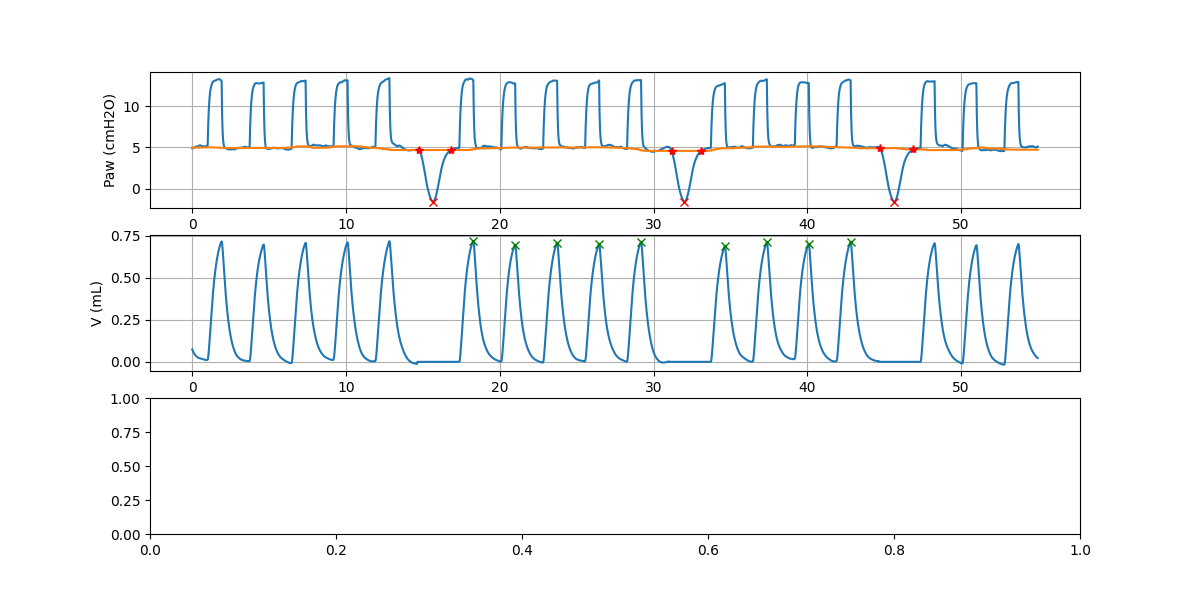

In [153]:
# Plot in-between supported breaths.
# Paw:
fig_1, axis = plt.subplots(nrows=3, ncols=1, figsize=(12, 6))
axis[0].grid(True)
#   Paw signal
axis[0].plot([y / vent_fs for y in range(len(Paw_sel))], Paw_sel)
#   Moving baseline
axis[0].plot([y / vent_fs for y in range(len(Paw_sel))],
             P_rolling_baseline)
#   Detected peaks, and on- and offsets
axis[0].plot(P_occ_peaks/vent_fs, Paw_sel[P_occ_peaks], "x", color="r")
axis[0].plot(P_occ_starts / vent_fs,
             P_rolling_baseline[P_occ_starts], '*r')
axis[0].plot(P_occ_ends / vent_fs,
             P_rolling_baseline[P_occ_ends], '*r')
axis[0].set_ylabel('Paw (cmH2O)')

# V_vent:
axis[1].grid(True)
axis[1].plot([y / vent_fs for y in range(len(Paw_sel))], V_t)
axis[1].set_ylabel('V (mL)')

#   Label supported breaths between Poccs with a green 'x'. Poccs that are not 
#   followed by a supported breaths are labeled as 'double dip' in the previous 
#   cell.
for idx in range(len(P_occ_peaks)):
    if idx > 0 :
        intermediate_breaths = np.equal(
            (P_occ_peaks[idx-1] < resp_efforts_volume  ), 
            (resp_efforts_volume < P_occ_peaks[idx]))
        axis[1].plot(
            resp_efforts_volume[intermediate_breaths]/vent_fs, 
            V_vent[resp_efforts_volume[intermediate_breaths]], "x", color="g")

# # sEAdi:
# axis[2].grid(True)
# N_samp = len(sEAdi[int(start_idx):int(end_s)])
# #   sEAdi signal
# axis[2].plot([y / emg_fs for y in range(N_samp)],
#              sEAdi[int(start_idx):int(end_s)])
# #   Moving baseline
# axis[2].plot([y / emg_fs for y in range(N_samp)],
#              sEAdi_rolling_baseline_aug[:int(end_s)-int(start_idx)])
# #   Detected peaks, and on- and offsets
# axis[2].plot(sEAdi_occ_peaks/emg_fs,
#              y_di_RMS[sEAdi_occ_peaks], "x", color="r")
# axis[2].plot(sEAdi_occ_starts_new/ emg_fs,
#              y_di_RMS[sEAdi_occ_starts_new], '*r')
# axis[2].plot(sEAdi_occ_ends_new / emg_fs,
#              y_di_RMS[sEAdi_occ_ends_new], '*r')
# axis[2].set_ylabel('sEAdi (uV)')
# axis[2].set_xlabel('t (s)')
# axis[2].set_ylim([0, 1.2*max(y_di_RMS[sEAdi_occ_peaks])])

10.b Pocc release quality

In [154]:
# Evaluate Pocc quality according to Paw 10th and 90th percentile of the upslope
t_vent = np.array(t_vent)

n_bins = 20
dP_up_10 = np.zeros((len(P_occ_peaks),))
dP_up_90 = np.zeros((len(P_occ_peaks),))
dP_up_90_norm = np.zeros((len(P_occ_peaks),))
for idx in range(len(P_occ_peaks)):

    start_i = P_occ_starts[idx]
    end_i = P_occ_ends[idx]

    dP_up_10[idx] = np.percentile(
        Paw_sel[P_occ_peaks[idx]+1:end_i]-Paw_sel[P_occ_peaks[idx]:end_i-1], 10)
    dP_up_90[idx] = np.percentile(
        Paw_sel[P_occ_peaks[idx]+1:end_i]-Paw_sel[P_occ_peaks[idx]:end_i-1], 90)
    
    dP_up_90_norm[idx] = dP_up_90[idx] / np.sqrt(PTP_occs[idx])

criteria_bool_matrix_local = np.array([
        dP_up_10 <= 0.0,
        dP_up_90 > 2.0,
        dP_up_90_norm > 0.8
    ])

In [159]:
criteria_bool_matrix_local = np.array([
        dP_up_10 <= 0.0,
        dP_up_90 > 2.0,
        dP_up_90_norm > 0.8
    ])

valid_poccs_local = ~np.any(~criteria_bool_matrix_local is False, axis=0)

(array([[False, False, False],
        [False, False, False],
        [False, False, False]]),
 True,
 array([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]),
 array([ True,  True,  True]))

In [160]:
qa.pocc_quality(Paw_sel, P_occ_peaks, P_occ_ends, PTP_occs)

(array([ True,  True,  True]),
 array([[0.0152638 , 0.01880832, 0.01201892],
        [0.09967941, 0.10041199, 0.09887405],
        [0.03759012, 0.03825545, 0.03730715]]))

10.c Interpeak time for ECG and sEAdi peaks 

In [ ]:
# # Determine electrophysiological interpeak distance
# t_delta_ecg_med = np.median(np.array(t_emg)[ECG_peaks[1:]] 
#                             - np.array(t_emg)[ECG_peaks[:-1]])
# t_delta_di_med = np.median(np.array(t_emg)[EMG_peaks_di[1:]] 
#                            - np.array(t_emg)[EMG_peaks_di[:-1]])

10.d sEAdi signal-to-noise ratio (SNR)

In [ ]:
# # Calculate signal-to-noise ratios. 
# #   As the true signal and noise are not known,
# #   the SNR is estimated as the maximum divided by the median of the moving 
# #   baseline in a 1 s window around the peak.

# SNR_di = qa.snr_pseudo(
#     src_signal=sEAdi[int(start_idx):int(end_s)], 
#     peaks=sEAdi_occ_peaks, 
#     baseline=sEAdi_rolling_baseline_aug[:int(end_s)-int(start_idx)]
# )

10.e Area under the baseline

In [ ]:
# # Plot the Area Under the Baseline (AUB) 
# # NB1 AUB is calculated above in step 9.
# # NB2 AUB is plotted in cyan 

# fig_2, axis = plt.subplots(nrows=2, ncols=max([len(
#     P_occ_peaks),2]), figsize=(12, 6), sharex='col', sharey='row')

# # Show EMG and Paw data for entire window
# t_plot_start = np.min([[P_occ_starts / vent_fs], 
#                     [sEAdi_occ_starts_new / emg_fs]], axis=0)[0] - 0.5
# t_plot_end = np.max([[P_occ_ends / vent_fs], 
#                      [sEAdi_occ_ends_new / emg_fs]], axis=0)[0] + 0.5

# # Plot sEAdi
# for idx in range(len(sEAdi_occ_peaks)):
#     start_i = sEAdi_occ_starts_new[idx]
#     end_i = sEAdi_occ_ends_new[idx]
#     start_plot_i = max([int(t_plot_start[idx] * emg_fs), 0])
#     end_plot_i = min([int(t_plot_end[idx] * emg_fs), len(t_emg)])
    
#     axis[0, idx].grid(True)
#     #   ECG-RMS for reference 
#     axis[0, idx].plot(t_emg[start_plot_i:end_plot_i], 
#                       ecg_rms[start_plot_i+205:end_plot_i+205]/
#                       max(ecg_rms[start_plot_i+205:end_plot_i+205])*
#                       max(y_di_RMS[start_plot_i:end_i]), 
#                       'tab:gray', linewidth=0.5)
#     #   sEAdi signal
#     axis[0, idx].plot(t_emg[start_plot_i:end_plot_i+1], 
#                       y_di_RMS[start_plot_i:end_plot_i+1])
#     #   Rolling baseline
#     axis[0, idx].plot(t_emg[start_plot_i:end_plot_i+1],
#                       sEAdi_rolling_baseline[start_plot_i:end_plot_i+1])
#     #   Area under the baseline (AUB)
#     axis[0, idx].plot([t_emg[start_i], t_emg[end_i+1]], 
#                       [y_di_min[idx], y_di_min[idx]], 'c')
#     axis[0, idx].plot([t_emg[start_i], t_emg[start_i]], 
#                       [y_di_RMS[start_i], y_di_min[idx]], 'c')
#     axis[0, idx].plot([t_emg[end_i], t_emg[end_i]], 
#                       [y_di_RMS[end_i], y_di_min[idx]], 'c')
#     #   Detected peaks, and on- and offsets
#     axis[0, idx].plot(t_emg[sEAdi_occ_peaks[idx]],
#                       y_di_RMS[sEAdi_occ_peaks[idx]], '*r')
#     axis[0, idx].plot(t_emg[start_i], y_di_RMS[start_i], '*r')
#     axis[0, idx].plot(t_emg[end_i], y_di_RMS[end_i], '*r')
#     axis[0, idx].set_ylim([0, 1.2*max(y_di_RMS[sEAdi_occ_peaks])])

# axis[0, 0].set_ylabel('sEAdi (uV)')

# # Plot Pocc
# for idx in range(len(P_occ_peaks)):
#     start_i = P_occ_starts[idx]
#     end_i = P_occ_ends[idx]
#     start_plot_i = max([int(t_plot_start[idx] * vent_fs), 0])
#     end_plot_i = min(
#         [int(t_plot_end[idx] * vent_fs), len(t_vent)])

#     axis[1, idx].grid(True)
#     #   Paw signal
#     axis[1, idx].plot(t_vent[start_plot_i:end_plot_i+1], 
#                       Paw_sel[start_plot_i:end_plot_i+1])
#     #   Moving baseline
#     axis[1, idx].plot(t_vent[start_plot_i:end_plot_i+1],
#                       P_rolling_baseline[start_plot_i:end_plot_i+1])    
#     #   Area under the baseline (AUB) 
#     axis[1, idx].plot([t_vent[start_i], t_vent[end_i+1]], 
#                       [Paw_max[idx], Paw_max[idx]], 'c')
#     axis[1, idx].plot([t_vent[start_i], t_vent[start_i]], 
#                       [Paw_sel[start_i], Paw_max[idx]], 'c')
#     axis[1, idx].plot([t_vent[end_i], t_vent[end_i]], 
#                       [Paw_sel[end_i], Paw_max[idx]], 'c')
#     #   Detected peaks, and on- and offsets
#     axis[1, idx].plot(t_vent[P_occ_peaks[idx]], Paw_sel[P_occ_peaks[idx]], '*r')
#     axis[1, idx].plot(t_vent[start_i], Paw_sel[start_i], '*r')
#     axis[1, idx].plot(t_vent[end_i], Paw_sel[end_i], '*r')

#     axis[1, idx].set_xlabel('t (s)')

# axis[1, 0].set_ylabel('Pocc (cmH2O)')

10.e Waveform morphology

In [ ]:
# # Evaluate sEAdi peak quality according to waveform morphology
# # NB1 Absolute bell error is calculated above in step 9.
# # NB2 The fitted bell curve is plotted in green 

# # Define the bell-curve function
# def func(x, a, b, c):
#     return a * np.exp(-(x-b)**2 / c**2)

# # Evaluate bell-curve error of sEAdidi peaks
# ETP_di_bell_error = np.zeros((len(sEAdi_occ_peaks),))
# for idx in range(len(sEAdi_occ_peaks)):
#     start_i = sEAdi_occ_starts_new[idx]
#     end_i = sEAdi_occ_ends_new[idx]
    
#     baseline_start_i = max([0, sEAdi_occ_peaks[idx] - 5*emg_fs])
#     baseline_end_i = min(
#         [len(y_di_RMS) - 1, sEAdi_occ_peaks[idx] + 5*emg_fs])
#     y_di_min[idx] = min(y_di_RMS[baseline_start_i:baseline_end_i])

#     # Too little samples to fit parameters to --> Add additional datapoints
#     if end_i - start_i < 3:
#         plus_idx = 3 - (end_i - start_i)
#     else:
#         plus_idx = 0
#     popt, pcov = curve_fit(func, 
#                     t_emg[start_i:end_i+1], 
#                     y_di_RMS[start_i:end_i+1]-y_di_min[idx],
#                     bounds=([0., t_emg[sEAdi_occ_peaks[idx]]-0.5, 0.], 
#                             [60., t_emg[sEAdi_occ_peaks[idx]]+0.5, 0.5])
#                     )

#     ETP_di_bell_error[idx] = np.trapz(
#         np.sqrt((y_di_RMS[start_i:end_i+1] - 
#         (func(t_emg[start_i:end_i+1], *popt)+y_di_min[idx])) **2),
#         dx=1/emg_fs
#     )

In [ ]:
# # Plot sEAdi peak quality according to waveform morphology

# fig_3, axis = plt.subplots(nrows=2, ncols=max([len(
#     P_occ_peaks), 2]), figsize=(12, 6), sharex='col', sharey='row')

# # Show EMG and Paw data for entire window
# t_plot_start = np.min([[P_occ_starts / vent_fs], 
#                     [sEAdi_occ_starts_new/ emg_fs]], axis=0)[0] - 0.5
# t_plot_end = np.max([[P_occ_ends / vent_fs], 
#                      [sEAdi_occ_ends_new / emg_fs]], axis=0)[0] + 0.5


# # Define the bell-curve function
# def func(x, a, b, c):
#     return a * np.exp(-(x-b)**2 / c**2)

# # Plot bell-curve error of sEAdi peaks
# # ETP_di_bell_error = np.zeros((len(sEAdi_occ_peaks),))
# for idx in range(len(sEAdi_occ_peaks)):
#     start_i = sEAdi_occ_starts_new[idx]
#     end_i = sEAdi_occ_ends_new[idx]
#     start_plot_i = max([int(t_plot_start[idx] * emg_fs), 0])
#     end_plot_i = min([int(t_plot_end[idx] * emg_fs), len(y_di_RMS)-1])
    
#     baseline_start_i = max([0, sEAdi_occ_peaks[idx] - 5*emg_fs])
#     baseline_end_i = min(
#         [len(y_di_RMS) - 1, sEAdi_occ_peaks[idx] + 5*emg_fs])
#     y_di_min[idx] = min(y_di_RMS[baseline_start_i:baseline_end_i])

#     # Too little samples to fit parameters to --> Add additional datapoints
#     if end_i - start_i < 3:
#         plus_idx = 3 - (end_i - start_i)
#     else:
#         plus_idx = 0
#     popt, pcov = curve_fit(func, 
#                     t_emg[start_i:end_i+1], 
#                     y_di_RMS[start_i:end_i+1]-y_di_min[idx],
#                     bounds=([0., t_emg[sEAdi_occ_peaks[idx]]-0.5, 0.], 
#                             [60., t_emg[sEAdi_occ_peaks[idx]]+0.5, 0.5])
#                     )

#     # Plot the fitted bell-curve relative to the sEAdi peak
#     axis[0, idx].grid(True)
#     # ECG-RMS for reference
#     axis[0, idx].plot(t_emg[start_plot_i:end_plot_i], 
#                       ecg_rms[start_plot_i+205:end_plot_i+205]/
#                       max(ecg_rms[start_plot_i+205:end_plot_i+205])*
#                       max(y_di_RMS[start_plot_i:end_i]), 
#                       'tab:gray', linewidth=0.5)
#     # sEAdi
#     axis[0, idx].plot(t_emg[start_plot_i:end_plot_i+1], 
#                       y_di_RMS[start_plot_i:end_plot_i+1])
#     # sEAdi moving baseline
#     axis[0, idx].plot(t_emg[start_plot_i:end_plot_i+1],
#                       sEAdi_rolling_baseline_aug[start_plot_i:end_plot_i+1])
#     # sEAdi peak, on- and off-set
#     axis[0, idx].plot(t_emg[sEAdi_occ_peaks[idx]],
#                       y_di_RMS[sEAdi_occ_peaks[idx]], '*r')
#     axis[0, idx].plot(t_emg[start_i], y_di_RMS[start_i], '*r')
#     axis[0, idx].plot(t_emg[end_i], y_di_RMS[end_i], '*r')
#     # Fitted bell-curve in green
#     axis[0, idx].plot(t_emg[start_plot_i:end_plot_i+1], 
#                       func(t_emg[start_plot_i:end_plot_i+1], *popt)
#                       + y_di_min[idx], 'g')
    

#     axis[0, idx].set_ylim([0, 1.2*max(y_di_RMS[sEAdi_occ_peaks])])

# axis[0, 0].set_ylabel('sEAdi (uV)')

# # Plot Paw
# # PTP_occ_bell_error = np.zeros((len(sEAdi_occ_peaks),))
# for idx in range(len(P_occ_peaks)):
#     start_i = P_occ_starts[idx]
#     end_i = P_occ_ends[idx]
#     start_plot_i = max([int(t_plot_start[idx] * vent_fs), 0])
#     end_plot_i = min(
#         [int(t_plot_end[idx] * vent_fs), len(Paw_sel)-1])
    
#     # Plot the fitted bell-curve relative to the Pocc peak
#     axis[1, idx].grid(True)
#     # Pocc peak with detected on- and offset and peak in red 
#     axis[1, idx].plot(t_vent[start_plot_i:end_plot_i+1], 
#                       Paw_sel[start_plot_i:end_plot_i+1])
#     # Pocc moving baseline
#     axis[1, idx].plot(t_vent[start_plot_i:end_plot_i+1],
#                       P_rolling_baseline[start_plot_i:end_plot_i+1])
#     # Pocc peak, on- and offset
#     axis[1, idx].plot(t_vent[P_occ_peaks[idx]], Paw_sel[P_occ_peaks[idx]], '*r')
#     axis[1, idx].plot(t_vent[start_i], Paw_sel[start_i], '*r')
#     axis[1, idx].plot(t_vent[end_i], Paw_sel[end_i], '*r')
#     axis[1, idx].set_xlabel('t (s)')

# axis[1, 0].set_ylabel('Paw (cmH2O)')

# print(ETP_di_bell_error)

## 11. Add the outcome data to a dataframe

In [ ]:
# # Store the output parameters in a dataframe (~ table)
# columns_now = ['patient', 'measurement', 'PEEP_set', 
#                    'PTP_occs', 'ETP_di_occs', 'NMC_di', 
#                    'SNR_di', 'PTP_occ_baseline', 'ETP_di_baseline', 
#                    'ETP_di_baseline_old', 'ETP_di_bell_SE',
#                    't_delta_di_med', 't_delta_ecg_med', 
#                    't_Pocc_peak', 't_Pocc_start', 't_Pocc_end',
#                    't_di_peak', 't_di_start', 't_di_end',
#                    'dP_up_10', 'dP_up_90', 'dP_up_90_norm', 'double_dip'
#                ]

# df = pd.DataFrame(big_data_list, columns=columns_now)

# if len(df[df['measurement'] == PEEP_step_chosen]) == 0:
#     for idx in range(len(PTP_occs)):
#         data_now = [patient, PEEP_step_chosen, PEEP_set, PTP_occs[idx],
#                     ETP_di_occs[idx], NMC_di[idx],
#                     SNR_di[idx],
#                     PTP_occ_baseline[idx], ETP_di_baseline[idx], 
#                     ETP_di_baseline_old[idx], ETP_di_bell_error[idx], 
#                     t_delta_di_med, t_delta_ecg_med,
#                     P_occ_peaks[idx]/vent_fs, 
#                     P_occ_starts[idx]/vent_fs, 
#                     P_occ_ends[idx]/vent_fs,
#                     sEAdi_occ_peaks[idx]/emg_fs, 
#                     sEAdi_occ_starts_new[idx]/emg_fs, 
#                     sEAdi_occ_ends_new[idx]/emg_fs,
#                     dP_up_10[idx], dP_up_90[idx], dP_up_90_norm[idx], 
#                     double_dips[idx],
#                     ]
        
#         big_data_list.append(data_now)
#         df = pd.DataFrame(big_data_list, columns=columns_now)

# df

In [ ]:
# # Generate read-me text file describing the used settings during analysis
# if gate_twice == True:
#     N_gated = 2
# else:
#     N_gated = 1

# context = (patient + ' / ' + measurement_date + ' / ' + PEEP_step_chosen + '\n'
#         +'t_start: ' + str(start) + ' s' + '\n'
#         +'t_end: ' + str(end) + ' s' + '\n'
#         +'gate_width: ' + str(int(gate_width*1000)) + ' ms' + '\n'
#         +'gate_threshold: ' + str(peak_fraction) + '' + '\n'
#         +'gate_ECG_shift: ' + str(ECG_shift) + ' samples' + '\n'
#         +'time_shift: ' + str(time_shift_default) + ' s' + '\n'
#         +'P_occ_prominence_factor: ' + str(P_occ_prominence_factor) 
#         + '' + '\n'
#         +'sEAdi_prominence_factor: ' + str(sEAdi_prominence_factor) 
#         + '' + '\n'
#         +'PEEP_set: ' + str(PEEP_set) + '' + '\n' \
#         +'N_gated: ' + str(N_gated) + '' + '\n' \
#         +'augmented_percentile: ' + str(augmented_perc) + ' %' + '\n'
#         +'analysis_date: ' + str(datetime.now()) + ''
#         )

# print(context)

In [ ]:
# if len(set(df['PEEP_set'].values)) < 4:
#     print('PEEP step ' + str(PEEP_step_chosen) + ' (' + 
#           str(len(set(df['PEEP_set'].values))) + '/4) is successfully evaluated' 
#           + 'and stored. Run the next PEEP step, starting at step 2C.')
# elif len(set(df['PEEP_set'].values)) == 4:
#     print('All 4 PEEP steps are evaluated. You may continue to step 12!')

## 12. Plot the NMCdi versus PEEP

In [ ]:
# # Print the calculated PTPocc, ETPdi and NMCdi
# output_fields = ['measurement', 'PEEP_set', 'PTP_occs', 'ETP_di_occs', 
#                'NMC_di']
# output_df = df[output_fields]

In [ ]:
# # Plot the all NMCdi values, permissible and impermissible
# bp = df.plot.scatter('PEEP_set', 'NMC_di')
# bp.set_ylabel('NMC_di (uV/cmH2O)')
# bp.set_xlabel('PEEP (cmH2O)')
# bp.set_title('Absolute NMCdi')
# ylims = bp.set_ylim()
# bp.set_ylim((0, ylims[1]))

In [ ]:
# cut_off_keys = ['strictness', 'double_dip', 'dP_up_10', 'dP_up_90', 
#                 'dP_up_90_norm', 't_delta_di_relative', 'SNR_di', 
#                 'ETP_di_AUB_relative', 'ETP_di_bell_relative']
# cut_off_values = np.array([['strict', 0, 0.0, 2.0, 0.8, 1.1, 1.75, 0.3, 0.25],
#                           ['tolerant', 0, 0.0, 2.0, 0.8, 1.1, 1.4, 0.4, 0.3]])

# cut_off_df = pd.DataFrame(cut_off_values, columns=cut_off_keys)

In [ ]:
# # Determine whether occlusions meet the strict and tolerant quality criteria

# # Extract the criteria values and normalise if necessary
# quality_fields_temp = ['measurement', 'double_dip', 'dP_up_10', 'dP_up_90', 
#                        'dP_up_90_norm', 't_delta_di_med', 't_delta_ecg_med', 
#                        'SNR_di', 'ETP_di_baseline', 'ETP_di_bell_SE']
# quality_df_temp = df[quality_fields_temp]
# quality_df_temp = quality_df_temp.assign(t_delta_di_relative=
#                                             quality_df_temp['t_delta_di_med'] / 
#                                             quality_df_temp['t_delta_ecg_med'])
# quality_df_temp = quality_df_temp.assign(ETP_di_AUB_relative=
#                                             quality_df_temp['ETP_di_baseline'] / 
#                                             output_df['ETP_di_occs'])
# quality_df_temp = quality_df_temp.assign(ETP_di_bell_relative=
#                                             quality_df_temp['ETP_di_bell_SE'] / 
#                                             output_df['ETP_di_occs'])

# quality_fields = ['measurement', 'double_dip', 'dP_up_10', 'dP_up_90', 
#                   'dP_up_90_norm', 't_delta_di_relative', 'SNR_di', 
#                   'ETP_di_AUB_relative', 'ETP_di_bell_relative']
# quality_df = quality_df_temp[quality_fields]

# quality_df_bool_fields = ['double_dip', 'Pocc', 'T_di', 'SNR_di', 
#                   'AUB_di', 'Bell_di']

# # Dataframes stating whether a manoeuvres passes the Strict criteria
# cut_off_keys_sel = ['double_dip', 'dP_up_10', 'dP_up_90', 
#                     'dP_up_90_norm', 't_delta_di_relative', 'SNR_di', 
#                     'ETP_di_AUB_relative', 'ETP_di_bell_relative']
# comp_mat_strict = np.matlib.repmat(
#     cut_off_df.loc[cut_off_df['strictness'] == 'strict', 
#                    cut_off_keys_sel].to_numpy(dtype=np.float32),
#     m = len(quality_df),
#     n = 1
# )
# quality_df_bool_data_strict = \
#     (quality_df[cut_off_keys_sel].values <= comp_mat_strict)
# quality_df_bool_data_strict[:, [1, 4, 5]] = \
#     quality_df_bool_data_strict[:, [1, 4, 5]] == False
# quality_df_bool_data_strict[:, 2] = np.prod(quality_df_bool_data_strict[:, 2:5],
#                                             axis=1)
# quality_df_bool_data_strict = np.delete(quality_df_bool_data_strict, 
#                                         [3, 4],
#                                         axis = 1)
# quality_df_bool_strict = pd.DataFrame(quality_df_bool_data_strict, 
#                                 columns=quality_df_bool_fields)
# quality_df_bool_strict = quality_df_bool_strict.assign(
#     measurement=quality_df['measurement'])

# # Dataframes stating whether a manoeuvres passes the Tolerant criteria 
# comp_mat_tolerant = np.matlib.repmat(
#     cut_off_df.loc[cut_off_df['strictness'] == 'tolerant', 
#                    cut_off_keys_sel].to_numpy(dtype=np.float32),
#     m = len(quality_df),
#     n = 1
# )
# quality_df_bool_data_tolerant = \
#     (quality_df[cut_off_keys_sel].values <= comp_mat_tolerant)
# quality_df_bool_data_tolerant[:, [1, 4, 5]] = \
#     quality_df_bool_data_tolerant[:, [1, 4, 5]] == False
# quality_df_bool_data_tolerant[:, 2] = np.prod(
#     quality_df_bool_data_tolerant[:, 2:5],
#     axis=1)
# quality_df_bool_data_tolerant = np.delete(quality_df_bool_data_tolerant, 
#                                         [3, 4],
#                                         axis = 1)
# quality_df_bool_tolerant = pd.DataFrame(quality_df_bool_data_tolerant, 
#                                 columns=quality_df_bool_fields)
# quality_df_bool_tolerant = quality_df_bool_tolerant.assign(
#     measurement=quality_df['measurement'])

# print('Strict:\n', quality_df_bool_tolerant, 
#       '\nTolerant:\n', quality_df_bool_tolerant)

In [ ]:
# # Normalise the ETPdi, PTPocc and NMCdi values relative to PEEP = 9 cmH2O:
# PEEP_norm = 9
# if len(set(df.loc[df['PEEP_set'] == PEEP_norm, 'PEEP_set'].values)) != 1:
#     print('Warning: PEEP = ', PEEP_norm, ' cmH2O is not available yet. ',
#           'Run that dataset first!')
# else:
#     # Strict
#     PTP_PEEP9_strict = np.median(output_df.loc[
#         quality_df_bool_strict.all(axis=1).values
#         & (df['PEEP_set'] == PEEP_norm), 
#         'PTP_occs']
#     )
#     ETP_PEEP9_strict = np.median(output_df.loc[
#         quality_df_bool_strict.all(axis=1).values
#         & (df['PEEP_set'] == PEEP_norm), 
#         'ETP_di_occs']
#     )
#     output_df = output_df.assign(PTP_norm_strict=
#                      output_df['PTP_occs'] / PTP_PEEP9_strict)
#     output_df = output_df.assign(ETP_norm_strict=
#                      output_df['ETP_di_occs'] / ETP_PEEP9_strict)
#     output_df = output_df.assign(NMC_di_norm_strict=
#                      output_df['PTP_norm_strict'] / 
#                      output_df['ETP_norm_strict'])
#     # Tolerant
#     PTP_PEEP9_tolerant = np.median(output_df.loc[
#         quality_df_bool_tolerant.all(axis=1).values
#         & (df['PEEP_set'] == PEEP_norm), 
#         'PTP_occs']
#     )
#     ETP_PEEP9_tolerant = np.median(output_df.loc[
#         quality_df_bool_tolerant.all(axis=1).values
#         & (df['PEEP_set'] == PEEP_norm), 
#         'ETP_di_occs']
#     )
#     output_df = output_df.assign(PTP_norm_tol=
#                      output_df['PTP_occs'] / PTP_PEEP9_tolerant)
#     output_df = output_df.assign(ETP_norm_tol=
#                      output_df['ETP_di_occs'] / ETP_PEEP9_tolerant)
#     output_df = output_df.assign(NMC_di_norm_tol=
#                      output_df['PTP_norm_tol'] / output_df['ETP_norm_tol'])

# print(output_df)

In [ ]:
# # Plot the normalised NMCdi values, permissible according to the tolerant 
# # criteria
# if len(set(df['PEEP_set'].values)) < 4:
#     print('Warning: Not 4 PEEP settings evaluated yet!')
# else:
#     passed_all_tolerant_crit = quality_df_bool_tolerant.all(axis=1)

#     bp = output_df[passed_all_tolerant_crit].plot.scatter('PEEP_set', 
#                                                    'NMC_di_norm_tol')
#     bp.set_ylabel('Normalised NMC_di (.)')
#     bp.set_xlabel('PEEP (cmH2O)')
#     bp.set_title('Normalised')
#     ylims = bp.set_ylim()
#     bp.set_ylim((0, ylims[1]))

In [ ]:
# # Plot the normalised NMCdi values, permissible according to the tolerant 
# # criteria
# if len(set(df['PEEP_set'].values)) < 4:
#     print('Warning: Not 4 PEEP settings evaluated yet!')
# else:
#     passed_all_tolerant_crit = quality_df_bool_strict.all(axis=1)

#     bp = output_df[passed_all_tolerant_crit].plot.scatter('PEEP_set', 
#                                                    'NMC_di_norm_strict')
#     bp.set_ylabel('Normalised NMC_di (.)')
#     bp.set_xlabel('PEEP (cmH2O)')
#     bp.set_title('Normalised')
#     ylims = bp.set_ylim()
#     bp.set_ylim((0, ylims[1]))